In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import feature, io, color
from skimage import io

## Import data

In [2]:
# Honey bee as 0.0
# Bumble bee as 1.0

labels = pd.read_csv('dataset/labels.csv', index_col=0)
labels.head()

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


In [3]:
def get_image(row_id, root='dataset/images/'):
    
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = io.imread(file_path)
    
    return img

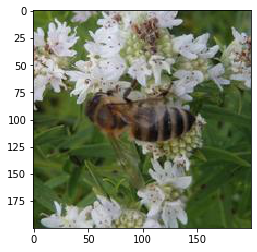

In [4]:
# Visualize Honey Bee
honey_bee_row = labels[labels.genus==0.0].index[5]
honey_bee = get_image(honey_bee_row)
plt.imshow(honey_bee)

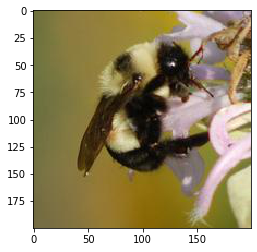

In [5]:
# Visualize Bumblee Bee

bumblee_bee_row = labels[labels.genus==1.0].index[5]
bumblee_bee = get_image(bumblee_bee_row)
plt.imshow(bumblee_bee)

## HOG Feature Extraction

In [6]:
images = []
X = []

for index, label in labels.iterrows():
    image = color.rgb2gray(get_image(index))
    images.append(image)
    X.append(feature.hog(image))

In [7]:
images = np.array(images)
images.shape

(3969, 200, 200)

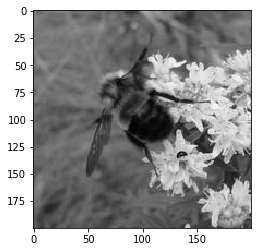

In [8]:
plt.imshow(images[0], cmap='gray')

In [9]:
X = np.array(X)
X.shape

(3969, 42849)

In [10]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,42839,42840,42841,42842,42843,42844,42845,42846,42847,42848
0,0.117828,0.036300,0.110423,0.043340,0.237136,0.228976,0.129474,0.023714,0.016248,0.164867,...,0.042505,0.206097,0.206097,0.122963,0.033568,0.108745,0.032978,0.020405,0.029403,0.050839
1,0.002690,0.010223,0.004285,0.012208,0.007799,0.009315,0.000606,0.000858,0.000000,0.446787,...,0.004397,0.150984,0.037285,0.009020,0.054604,0.263313,0.130639,0.058526,0.029596,0.015118
2,0.120735,0.005582,0.010744,0.000000,0.033404,0.092792,0.271779,0.075416,0.054884,0.070181,...,0.000000,0.008203,0.009171,0.000000,0.000000,0.151755,0.000000,0.011601,0.009171,0.000000
3,0.043037,0.017653,0.032078,0.028387,0.054606,0.050535,0.030649,0.002185,0.000000,0.097704,...,0.062824,0.231846,0.119026,0.196763,0.088491,0.180951,0.116490,0.114397,0.030005,0.074543
4,0.247354,0.260233,0.082376,0.043293,0.067401,0.014359,0.027829,0.037508,0.089570,0.178646,...,0.050441,0.152423,0.212177,0.028512,0.041321,0.021434,0.092857,0.105532,0.099534,0.013553


In [11]:
y = labels.copy()
y.head()

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


In [12]:
len(labels[labels.genus==0.0])

827

In [13]:
len(labels[labels.genus==1.0])

3142

A lot more honey bees than bumble bees.

## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=27)

In [16]:
len(y_train[y_train.genus==0.0])

620

In [17]:
len(y_test[y_test.genus==0.0])

207

In [18]:
len(y_train[y_train.genus==1.0])

2356

In [19]:
len(y_test[y_test.genus==1.0])

786

## Model Building

In [20]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [21]:
import pickle
from pathlib import Path

def pickle_exists(filename):
    file = Path('models2/' + filename + '.pkl')
    if file.is_file():
        return True
    return False

def save_model(model, filename):
    pickle.dump(model, open('models2/' + filename + '.pkl', 'wb'))
    
def load_model(filename):
    return pickle.load(open('models2/' + filename + '.pkl', 'rb'))

In [22]:
scorer = make_scorer(f1_score, average='macro')

def get_f1_score_of_model(model, x_test, y_test):
    y_predictions = model.predict(x_test)
    return f1_score(y_test, y_predictions, average='macro')
    
def grid_search_classifier(classifier, x_train, y_train, x_test, y_test, grid_params):
    clf = GridSearchCV(classifier(), grid_params, scoring=scorer)
    clf.fit(x_train, y_train)
    best_model = classifier(**clf.best_params_)
    best_model.fit(x_train, y_train)
    return best_model, get_f1_score_of_model(best_model, x_test, y_test)

In [23]:
random_state = [27]
verbose = [10]
classifiers = [
    (LogisticRegression, 
    {
        'C': (1,5,10),
        'max_iter': (100,500,1000),
        'verbose': verbose,
        'random_state': random_state,
    },
    'logistic_regression'),
    (DecisionTreeClassifier, 
     {
         'max_depth': (3,5,9),
         'min_samples_split': (2,6,10),
         'splitter': ('best', 'random'),
         'random_state': random_state
     },
    'decision_tree'),
    (SGDClassifier, 
     {
         'alpha': (0.0001,0.001,1),
         'max_iter': (100,500,1000),
         'learning_rate': ('optimal', 'adaptive'),
         'eta0': (0.01, 0.1, 0.5, 1.0),
         'verbose': verbose,
         'random_state': random_state
     },
    'sgd')
]

In [24]:
summary = []

for classifier, grid_params, filename in classifiers:
    if pickle_exists(filename):
        print('\nPickle already exists for ' + classifier.__name__ + '. Loading from file...')
        model = load_model(filename)
        score = get_f1_score_of_model(model, X_test, y_test)
    else:
        print('\nNo pickle found for ' + classifier.__name__ + '. Training model and saving to file...')
        model, score = grid_search_classifier(classifier, X_train, y_train, X_test, y_test, grid_params)
        save_model(model, filename)
    print(model)
    print('\nF1 Score for ' + classifier.__name__ + ': ')
    print(score)
    summary.append({'Classifier': classifier.__name__, 'F1 Score': score})
    
pd.DataFrame(summary)


Pickle already exists for LogisticRegression. Loading from file...
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=27, solver='lbfgs', tol=0.0001, verbose=10,
                   warm_start=False)

F1 Score for LogisticRegression: 
0.5469521154516706

Pickle already exists for DecisionTreeClassifier. Loading from file...
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='random')

F1 Score for DecisionTreeClassifier: 
0.5193256231184082



,Classifier,F1 Score
0,LogisticRegression,0.546952
1,DecisionTreeClassifier,0.519326
2,SGDClassifier,0.545522


Classifier|F1Score|Best Params|
----------|-------|-----------|
Logistic Regression|0.546952|C=5<br>max_iter=500
Decision Tree|0.519326|max_depth=9<br>min_samples_split=2<br>splitter=random
Stochastic Gradient Descent|0.545522|alpha=0.001<br>max_iter=100<br>learning_rate=adaptive<br>eta0=0.5

In [25]:
model = load_model('logistic_regression')

In [26]:
predicted_labels = model.predict(X_test)

In [27]:
len(predicted_labels)

993

## Test on new images 

In [28]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,42839,42840,42841,42842,42843,42844,42845,42846,42847,42848
3116,0.252127,0.000000,0.000000,0.000000,0.046526,0.052018,0.032899,0.026009,0.000000,0.252127,...,0.066048,0.096257,0.024493,0.018922,0.029899,0.024520,0.078707,0.069155,0.003283,0.019325
408,0.050170,0.007980,0.009433,0.140917,0.263091,0.263091,0.102569,0.000000,0.000000,0.134597,...,0.028412,0.102961,0.059021,0.244633,0.167506,0.154916,0.056228,0.132570,0.033040,0.015194
618,0.052899,0.032204,0.081545,0.130579,0.071669,0.025696,0.010866,0.006895,0.005053,0.152658,...,0.009968,0.134773,0.232266,0.085540,0.042495,0.128491,0.000000,0.008758,0.057584,0.000000
2767,0.162021,0.000000,0.000000,0.000000,0.063088,0.000000,0.056631,0.081730,0.297232,0.066619,...,0.008633,0.213568,0.165934,0.060505,0.019217,0.096515,0.023865,0.019585,0.018940,0.000000
1359,0.399838,0.013680,0.011798,0.000000,0.011947,0.007307,0.016973,0.012980,0.367656,0.069720,...,0.012427,0.319048,0.056588,0.024761,0.283408,0.267627,0.319048,0.212454,0.149941,0.020870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,0.028343,0.006279,0.005087,0.061999,0.125935,0.056453,0.039793,0.001856,0.000000,0.044964,...,0.089373,0.122007,0.013437,0.018841,0.024462,0.182338,0.117162,0.111807,0.124119,0.026115
346,0.042851,0.019985,0.054695,0.151759,0.271750,0.068696,0.010527,0.004154,0.009537,0.271750,...,0.060646,0.189505,0.074133,0.113373,0.000000,0.015672,0.001365,0.001646,0.017140,0.069926
3370,0.220225,0.220225,0.220225,0.010351,0.157449,0.080729,0.045139,0.101332,0.052629,0.155078,...,0.164444,0.146029,0.001791,0.000000,0.000000,0.086860,0.000000,0.239511,0.239511,0.209389
954,0.051981,0.066787,0.046966,0.066820,0.083469,0.077824,0.012440,0.017371,0.034621,0.258760,...,0.135979,0.102504,0.018787,0.038236,0.032630,0.083410,0.054771,0.139037,0.094356,0.024837


In [29]:
y_test.head(50)

,genus
id,
4953,1.0
4117,1.0
4364,1.0
312,0.0
1229,1.0
2491,0.0
3733,1.0
1866,1.0
4383,1.0


In [30]:
def get_bee_type(label):
    return 'Honey Bee' if label == 0.0 else 'Bumble Bee'

def get_bee(id):
    plt.imshow(get_image(id))
    index = y_test.index.get_loc(id)
    predicted_label = predicted_labels[index]
    actual_label = y_test.iloc[index].genus
    print('Actual: ')
    print(actual_label)
    print(get_bee_type(actual_label))
    print('\nPredicted: ') 
    print(predicted_label)
    print(get_bee_type(predicted_label))

Actual: 
1.0
Bumble Bee

Predicted: 
1.0
Bumble Bee


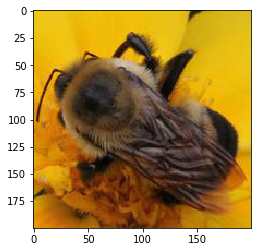

In [31]:
get_bee(4953)

Actual: 
1.0
Bumble Bee

Predicted: 
1.0
Bumble Bee


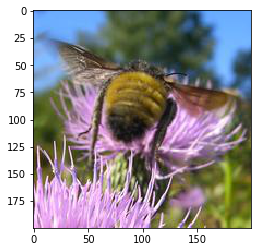

In [32]:
get_bee(4117)

Actual: 
0.0
Honey Bee

Predicted: 
0.0
Honey Bee


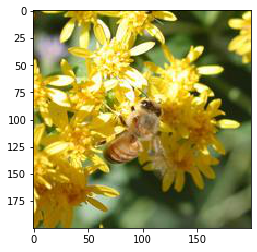

In [33]:
get_bee(2491)

Actual: 
0.0
Honey Bee

Predicted: 
1.0
Bumble Bee


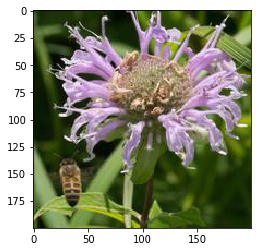

In [34]:
get_bee(312)

Actual: 
1.0
Bumble Bee

Predicted: 
0.0
Honey Bee


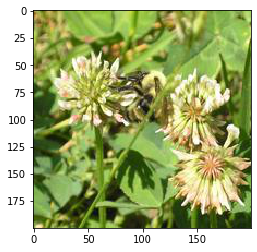

In [35]:
get_bee(3580)